![image.png](https://i.imgur.com/a3uAqnb.png)

# Image Captioning with a CNN-Transformer Architecture

This notebook demonstrates how to build a modern image captioning model using an encoder-decoder architecture with a **Transformer Decoder**. This approach is a step up from the classic RNN/LSTM-based decoders and is closer to the state-of-the-art.

### **📌 The Core Idea: Encoder-Decoder**
The model consists of two main parts that work together:

1.  **The Encoder**: A pre-trained Convolutional Neural Network (CNN), ResNet-50, acts as the encoder. It takes an image as input and outputs a compact feature vector (an embedding). This vector is a rich, numerical representation of the image's content.

2.  **The Decoder**: A **Transformer Decoder** acts as the language model. It takes the image's feature vector from the encoder and generates the caption one word at a time. Unlike an RNN which processes words sequentially, the Transformer uses **self-attention** to process all previously generated words simultaneously, allowing it to better capture long-range dependencies in the text.

In [1]:
from IPython.display import display

In [2]:
# %pip install torch torchvision pillow spacy numpy pandas tqdm kagglehub matplotlib
# %pip install torchtext
# %pip install pycocotools

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import random
from tqdm import tqdm
import kagglehub
import pandas as pd
from PIL import Image
import spacy
from IPython.display import display
import pickle
import os
import math
import matplotlib.pyplot as plt

## 1️⃣ The Dataset: Flickr8k
We will use the Flickr8k dataset, a popular benchmark for image captioning. It contains:
- **8,000 Images**: Sourced from the Flickr website.
- **40,000 Captions**: Each image is paired with five different human-generated captions, providing a rich variety of descriptions.

First, we'll download the dataset from Kaggle Hub and inspect its contents.

In [4]:
# Download the Flickr8k dataset
path = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", path)

Path to dataset files: /home/ali/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [5]:
# Load the captions from the `captions.txt` file
captions_path = os.path.join(path, "captions.txt")
captions_df = pd.read_csv(captions_path)
print(f"Captions loaded: {len(captions_df)} entries")
print(captions_df.head())

Captions loaded: 40455 entries
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [6]:
# Images directory
images_dir = os.path.join(path, "Images")
print(f"Images directory: {images_dir}")
print(f"Number of images: {len(os.listdir(images_dir))}")

Images directory: /home/ali/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images
Number of images: 8091


Sample caption: A child in a pink dress is climbing up a set of stairs in an entry way .


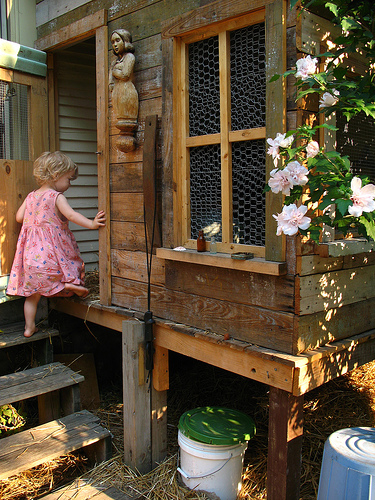

In [7]:
# Let's look at a sample image and one of its captions
print("Sample caption:", captions_df.iloc[0]['caption'])
sample_image_path = os.path.join(images_dir, captions_df.iloc[0]['image'])
sample_img = Image.open(sample_image_path)
display(sample_img)

## 2️⃣ Building the Vocabulary

Neural networks work with numbers, not words. Therefore, we need to build a **vocabulary** to map every unique word in our dataset to a unique integer index. We also add special tokens that are crucial for the training process:

- `<PAD>`: A padding token used to make all sequences in a batch the same length.
- `<SOS>`: A "Start of Sentence" token that signals the beginning of a caption to the decoder.
- `<EOS>`: An "End of Sentence" token that the model learns to predict when it has finished generating a caption.
- `<UNK>`: An "Unknown" token for words that appear in the test set but not in our training vocabulary.

We use the `spaCy` library for robust and efficient tokenization.

In [8]:
spacy_eng = spacy.load("en_core_web_sm") # you might need to run this: python -m spacy download en_core_web_sm

In [9]:
def word_tokenize(text):
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

In [10]:
# Initialize vocabulary with special tokens
word_to_index = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
index_to_word = {idx: word for word, idx in word_to_index.items()}
word_freq = {}

# Build vocabulary from all captions in the dataset
for caption in tqdm(captions_df['caption']):
    tokens = word_tokenize(caption.lower())
    
    for token in tokens:
        if token not in word_to_index:
            idx = len(word_to_index)
            word_to_index[token] = idx
            index_to_word[idx] = token
            word_freq[token] = 1
        else:
            word_freq[token] += 1

print(f"\nVocabulary size: {len(word_to_index)}")

100%|██████████| 40455/40455 [00:00<00:00, 81897.23it/s]


Vocabulary size: 8508


## 3️⃣ The Model: A CNN-Transformer Encoder-Decoder
Our model is composed of two main modules: an Encoder to process the image and a Decoder to generate the text.

### 🔹 The Encoder (CNN)
We use a pre-trained ResNet-50 model, which has already learned rich feature representations from the large ImageNet dataset. We perform two key modifications:
1.  **Freeze Layers**: We freeze all the convolutional layers (`requires_grad_(False)`) to prevent them from being updated during training. This is a form of transfer learning that speeds up training and prevents overfitting.
2.  **Replace Classifier**: We chop off the final, fully-connected classification layer (which originally predicts 1000 ImageNet classes) and replace it with a new `nn.Linear` layer. This new layer will output a feature vector of `embed_size`, which will be the input to our decoder.

### 🔹 The Decoder (Transformer)
The decoder is a Transformer, a powerful architecture for sequence-to-sequence tasks. It has several key components:

1.  **Embedding Layer**: Converts the integer-coded words of the caption into dense vectors of size `embed_size`.
2.  **Positional Encoding**: Since the transformer processes all words at once (unlike an RNN), it has no inherent sense of word order. We add a *positional encoding* to the word embeddings to give the model information about the position of each word in the sequence.
3.  **Transformer Decoder Layers**: The core of the decoder. Each layer has two main sub-layers:
    - **Masked Self-Attention**: Allows the decoder to weigh the importance of different words in the *already generated* part of the caption. The "masking" is crucial: it prevents the model from cheating by looking ahead at future words during training.
    - **Encoder-Decoder Attention**: This is where the model looks at the image. It allows the decoder to focus on the image feature vector provided by the encoder, connecting the visual information to the text being generated.
4.  **Linear Layer**: A final linear layer maps the transformer's output to the size of our vocabulary, producing a probability distribution over all possible next words.

In [11]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()

        # Use a pretrained ResNet-50 and freeze its parameters
        self.resnet = models.resnet50(weights='IMAGENET1K_V1').requires_grad_(False)
        # Replace the final fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.resnet(images)
        return self.dropout(self.relu(features))


class PositionalEncoding(nn.Module):
    """Injects positional information into the input embeddings."""
    def __init__(self, d_model, max_seq_length=100):
        super(PositionalEncoding, self).__init__()
        # Create a buffer for the positional encoding matrix. It's not a model parameter.
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0)) # Add batch dimension

    def forward(self, x):
        # x is expected to be of shape [batch_size, seq_length, embed_size]
        # Add the positional encoding to the input embeddings
        return x + self.pe[:, :x.size(1), :]


class DecoderTransformer(nn.Module):
    def __init__(self, embed_size, heads, num_layers, vocab_size, max_seq_length):
        super(DecoderTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.position_encoding = PositionalEncoding(embed_size, max_seq_length)
        
        # A single transformer decoder layer
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=heads, batch_first=True)
        # Stack multiple decoder layers
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        self.fc = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions, tgt_mask):
        # Embed captions and add positional encoding
        embeddings = self.dropout(self.position_encoding(self.embedding(captions)))
        
        # The image features are the 'memory' for the decoder
        features = features.unsqueeze(1)
        
        # Pass inputs through the transformer decoder
        # tgt_mask prevents attending to future tokens
        output = self.transformer_decoder(tgt=embeddings, memory=features, tgt_mask=tgt_mask)
        return self.fc(output)


class ImageCaptioner(nn.Module):
    """A wrapper model combining the Encoder and Decoder."""
    def __init__(self, embed_size, heads, vocab_size, num_layers, max_seq_length):
        super(ImageCaptioner, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderTransformer(embed_size, heads, num_layers, vocab_size, max_seq_length)
        self.max_seq_length = max_seq_length
    
    def _create_tgt_mask(self, sz, device):
        """Creates a square upper-triangular mask for preventing attention to future tokens."""
        return nn.Transformer.generate_square_subsequent_mask(sz).to(device)

    def forward(self, images, captions):
        features = self.encoder(images)
        # The target mask is needed for the decoder's self-attention
        tgt_mask = self._create_tgt_mask(captions.size(1), captions.device)
        outputs = self.decoder(features, captions, tgt_mask)
        return outputs

    def caption_image(self, image, max_length=50):
        """Autoregressive caption generation for inference."""
        result_caption_indices = [word_to_index['<SOS>']]

        with torch.no_grad():
            features = self.encoder(image)
            for _ in range(max_length -1):
                caption_so_far = torch.LongTensor(result_caption_indices).unsqueeze(0).to(image.device)
                
                # Get model output for the current sequence
                output = self.forward(image, caption_so_far)
                
                # We are only interested in the prediction for the *next* word
                predicted_idx = output.argmax(2)[:, -1].item()
                result_caption_indices.append(predicted_idx)

                if predicted_idx == word_to_index['<EOS>']:
                    break
        
        # Convert indices back to words
        result_caption = [index_to_word.get(idx, '<UNK>') for idx in result_caption_indices]
        return result_caption[1:] # Exclude <SOS>

## 4️⃣ The PyTorch Dataset and DataLoader
We create a custom `Flickr8kDataset` class to interface with our data. This is the standard PyTorch way to prepare data for a `DataLoader`.

The `__getitem__` method is the most important part. For a given index `idx`, it performs these steps:
1.  Loads the image and its corresponding caption from our dataframe.
2.  Applies the necessary image transformations (resizing to a fixed size, converting to a tensor, and normalizing).
3.  Tokenizes the caption, converts it to a sequence of indices, and adds the `<SOS>` and `<EOS>` tokens.
4.  Pads the caption tensor with the `<PAD>` token index so that all sequences in a batch have the same length (`max_seq_len`). This is required for batch processing.

In [12]:
def convert_sentence_to_idxs(sentence):
    words = word_tokenize(sentence)
    idxs = [word_to_index.get(word, word_to_index['<UNK>']) for word in words] 
    return idxs

def convert_idxs_to_sentence(idxs):
    words = [index_to_word[idx] for idx in idxs]
    return ' '.join(words)

class Flickr8kDataset(Dataset):
    def __init__(self, captions_df, images_dir, max_seq_len, transform):
        self.captions_df = captions_df
        self.images_dir = images_dir
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        row = self.captions_df.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.images_dir, row['image'])
        img = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            img = self.transform(img)
        
        # Process caption
        caption = row['caption'].lower().strip()
        caption_idxs = convert_sentence_to_idxs(caption)
        
        # Truncate if caption is too long
        if len(caption_idxs) > self.max_seq_len - 2:  # 2 for SOS and EOS
            caption_idxs = caption_idxs[:self.max_seq_len-2]

        # Calculate padding length
        padding_len = self.max_seq_len - len(caption_idxs) - 2

        # Create the final tensor with special tokens and padding
        caption_tensor = (
            [word_to_index['<SOS>']] +
            caption_idxs +
            [word_to_index['<EOS>']] +
            [word_to_index['<PAD>']] * padding_len
        )

        caption_tensor = torch.tensor(caption_tensor, dtype=torch.long)
        return img, caption_tensor

In [13]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # ImageNet stats
])

# For demonstration purposes, we'll train on a small subset of the data.
# Increase this for better results!
train_size = min(5000, len(captions_df))
train_captions = captions_df.head(train_size)

batch_size = 32
max_seq_len = 50 # Max caption length

train_dataset = Flickr8kDataset(train_captions, images_dir, max_seq_len=max_seq_len, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"Training on {len(train_dataset)} image-caption pairs")

Training on 5000 image-caption pairs


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 5️⃣ Model Training
Now we define the hyperparameters, initialize the model, and set up the optimizer and loss function for training.

### 🔹 Hyperparameters & Setup
These are the key settings for our model and training process. Tuning these can significantly impact performance.

In [15]:
embed_size = 512
heads = 8 # Number of attention heads in the Transformer
vocab_size = len(word_to_index)
num_decoder_layers = 4
learning_rate = 1e-4
num_epochs = 15 # Increased for better results, but still short for a full training

### 🔹 Loss Function and Optimizer
- **Loss Function**: We use `nn.CrossEntropyLoss`. This is the standard choice for multi-class classification, which is what we're doing at each time step—predicting the next word from the entire vocabulary.
Importantly, we set `ignore_index=word_to_index['<PAD>']`. This tells the loss function to ignore the `<PAD>` tokens when calculating the loss, so the model isn't penalized for its predictions on padded parts of the sequence.

- **Optimizer**: We use the Adam optimizer, a popular and effective choice for deep learning models.

In [16]:
# Initialize model, loss, and optimizer
model = ImageCaptioner(embed_size, heads, vocab_size, num_decoder_layers, max_seq_len).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index['<PAD>']) 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Only finetune the final layer of the CNN encoder
for name, param in model.encoder.resnet.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

### 🔹 Pre-training Check
Before we start training, let's see what our randomly initialized model produces. We expect the captions to be nonsensical.

In [17]:
# Prepare a few random test samples
test_samples = []
test_images = []

random_indices = random.sample(range(len(captions_df)), min(3, len(captions_df)))

for i in random_indices:
    row = captions_df.iloc[i]
    img_path = os.path.join(images_dir, row['image'])
    img = Image.open(img_path).convert('RGB')
    
    test_samples.append({'image': img, 'caption': row['caption']})
    img_tensor = transform(img).to(device)
    test_images.append(img_tensor)

--- Pre-training captions ---


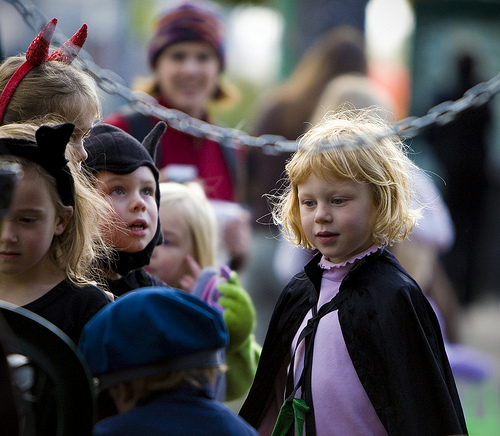

Generated: confronting stuffed kayak agile trekkies rappeling agile mittened instructing ceremonial agile mittened instructing instructing instructing zig rappeling rappeling agile mittened instructing smiff skiing instructing lighter instructing soldier zig surfers instructing lighter embankment instructing citizens harbor broom partition thw cat passage scared instructing nascar soldier broom new sleek because tone
Original: A blonde girl in a black cape stands with other children in costumes .
--------------------------------------------------


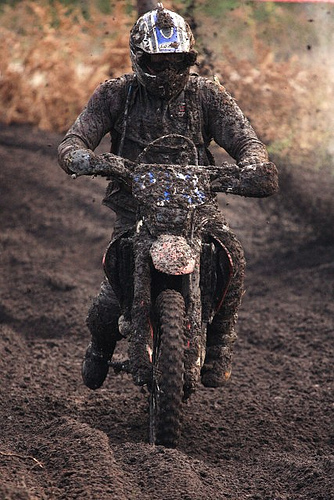

Generated: confronting garmet hill sequined rappeling rappeling rappeling fixing incoming zig bass waded kayak avoids new new new prairie zig bass pastry drilling map last firecracker rockets agile firecracker rockets agile sedan crib peers texting archway glassess calico drilling map thw stuffed homemade mountain led roading instructing grate rafting because
Original: Man in a helmet riding a dirt bike covered with mud .
--------------------------------------------------


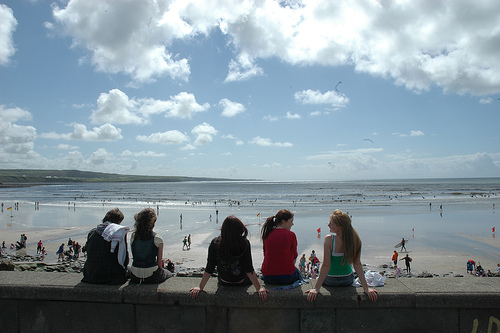

Generated: confronting stuffed kayak soap pressing fun zig bass pastry zig bass pastry zig bass pastry zig bass pastry mic soap kicking fencing pastry fun geological kicking zig surfers homemade waterskis pastry headfirst wigs zombie broom using broom using broom pastry mic stuffed homemade local above competing organized mic solo
Original: Crowd of people at the beach .
--------------------------------------------------


In [18]:
print("--- Pre-training captions ---")
model.eval()
for i, sample in enumerate(test_samples):
    display(sample['image'])
    
    with torch.no_grad():
        # The model's `caption_image` expects a batch, so we add a dimension with unsqueeze(0)
        caption = model.caption_image(test_images[i].unsqueeze(0))
        caption_text = ' '.join(caption)
        print(f"Generated: {caption_text}")
        print(f"Original: {sample['caption']}")
        print("-" * 50)

### 🔹 The Training Loop
The training process involves iterating through the dataset for a number of epochs. In each step:

1.  **Prepare Inputs and Targets**: We use the ground-truth caption for both input and target, but shifted. The input to the decoder is the caption from `<SOS>` to the second-to-last word (`captions[:, :-1]`). The model's goal is to predict the next word at each position, so the target is the caption from the first word to `<EOS>` (`captions[:, 1:]`).
2.  **Generate Causal Mask**: A crucial step for the Transformer. We create a mask to prevent the decoder from attending to "future" tokens in the sequence during training. This enforces the auto-regressive property, ensuring the prediction for a word at position `i` only depends on the known words before it.
3.  **Calculate Loss**: The model's output (logits) is compared against the target sequence to calculate the loss.
4.  **Backpropagation**: The loss is backpropagated through the network to compute gradients.
5.  **Optimizer Step**: The optimizer updates the model's trainable parameters (the decoder and the final layer of the encoder).

In [19]:
epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for idx, (imgs, captions) in tqdm(
        enumerate(train_loader), total=len(train_loader), leave=False,
        desc=f"Epoch {epoch+1}/{num_epochs}"
    ):
        imgs = imgs.to(device)
        captions = captions.to(device)

        # The input to the decoder is the sequence up to the second to last word
        # The target is the sequence from the second word to the end
        decoder_input = captions[:, :-1]
        targets = captions[:, 1:]
        
        # Forward pass
        outputs = model(imgs, decoder_input)
        
        # Reshape for CrossEntropyLoss and calculate loss
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]),  # Shape: [batch_size * (seq_len-1), vocab_size]
            targets.flatten()                       # Shape: [batch_size * (seq_len-1)]
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss) # Save loss for plotting
    print(f'Epoch: {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')
    
    # Test generation every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        print(f"\n--- Testing after epoch {epoch+1} ---")
        with torch.no_grad():
            test_caption = model.caption_image(test_images[0].unsqueeze(0))
            print(f"Generated: {' '.join(test_caption)}")
            print(f"Original: {test_samples[0]['caption']}")
        print("-" * 50)

Epoch: 1/15, Average Loss: 5.2036


Epoch: 2/15, Average Loss: 4.0787


Epoch: 3/15, Average Loss: 3.7688


Epoch: 4/15, Average Loss: 3.5569


Epoch: 5/15, Average Loss: 3.4045

--- Testing after epoch 5 ---
Generated: a man in a red shirt is standing on a rock . <EOS>
Original: A blonde girl in a black cape stands with other children in costumes .
--------------------------------------------------


Epoch: 6/15, Average Loss: 3.2672


Epoch: 7/15, Average Loss: 3.1593


Epoch: 8/15, Average Loss: 3.0554


Epoch: 9/15, Average Loss: 2.9609


Epoch: 10/15, Average Loss: 2.8775

--- Testing after epoch 10 ---
Generated: a woman in a red shirt and black pants is sitting on a bench . <EOS>
Original: A blonde girl in a black cape stands with other children in costumes .
--------------------------------------------------


Epoch: 11/15, Average Loss: 2.7946


Epoch: 12/15, Average Loss: 2.7151


Epoch: 13/15, Average Loss: 2.6499


Epoch: 14/15, Average Loss: 2.5803


Epoch: 15/15, Average Loss: 2.5158

--- Testing after epoch 15 ---
Generated: a man in a white shirt and sunglasses is standing in front of a crowd of people . <EOS>
Original: A blonde girl in a black cape stands with other children in costumes .
--------------------------------------------------


### 🔹 Plotting the Training Progress
Visualizing the loss helps us understand how well the model is learning. A decreasing loss indicates that the model is successfully minimizing its prediction error over time.

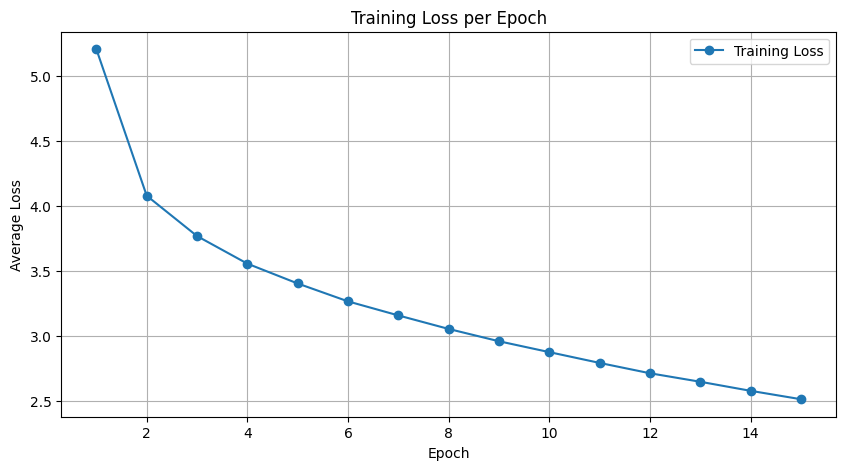

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, 'o-', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

## 6️⃣ Saving and Loading the Model

To avoid retraining the model every time we want to use it, we can save its state. It's good practice to save three things:
1.  **Model State Dictionary**: The learned weights and biases of the model.
2.  **Vocabulary Mappings**: The `word_to_index` and `index_to_word` dictionaries are essential for converting between words and indices during inference.
3.  **Model Configuration**: The hyperparameters used to build the model (`embed_size`, `heads`, etc.), so we can perfectly reconstruct the architecture before loading the weights.

In [21]:
def save_model(model, word_to_index, index_to_word, model_config, save_dir="flickr8k_transformer_captioning_model"):
    """
    Save the trained model, vocabulary, and configuration to a specified directory.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model state dict
    model_path = os.path.join(save_dir, 'flickr8k_transformer_captioner.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model state dict saved to '{model_path}'")
    
    # Save vocabulary mappings
    vocab_data = {
        'word_to_index': word_to_index,
        'index_to_word': index_to_word,
        'vocab_size': len(word_to_index)
    }
    vocab_path = os.path.join(save_dir, 'vocab_mappings.pkl')
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab_data, f)
    print(f"Vocabulary mappings saved to '{vocab_path}'")
    
    # Save model configuration
    config_path = os.path.join(save_dir, 'model_config.pkl')
    with open(config_path, 'wb') as f:
        pickle.dump(model_config, f)
    print(f"Model configuration saved to '{config_path}'")
    
    print(f"\nAll files saved successfully in '{save_dir}' directory!")

In [22]:
# Define the model configuration to be saved
model_config = {
    'embed_size': embed_size,
    'heads': heads,
    'vocab_size': vocab_size,
    'num_decoder_layers': num_decoder_layers,
    'max_seq_len': max_seq_len
}

# Save the current trained model
save_model(model, word_to_index, index_to_word, model_config)

Model state dict saved to 'flickr8k_transformer_captioning_model/flickr8k_transformer_captioner.pth'
Vocabulary mappings saved to 'flickr8k_transformer_captioning_model/vocab_mappings.pkl'
Model configuration saved to 'flickr8k_transformer_captioning_model/model_config.pkl'

All files saved successfully in 'flickr8k_transformer_captioning_model' directory!


In [23]:
def load_model(save_dir="flickr8k_transformer_captioning_model", device='cpu'):
    """
    Load the trained model, vocabulary, and configuration from a specified directory.
    """
    # Load vocabulary mappings
    vocab_path = os.path.join(save_dir, 'vocab_mappings.pkl')
    with open(vocab_path, 'rb') as f:
        vocab_data = pickle.load(f)
    print(f"Vocabulary mappings loaded from '{vocab_path}'")
    
    # Load model configuration
    config_path = os.path.join(save_dir, 'model_config.pkl')
    with open(config_path, 'rb') as f:
        config = pickle.load(f)
    print(f"Model configuration loaded from '{config_path}'")
    
    # Recreate model architecture using the loaded config
    model = ImageCaptioner(
        config['embed_size'], 
        config['heads'], 
        config['vocab_size'], 
        config['num_decoder_layers'],
        config['max_seq_len']
    )
    
    # Load model weights
    model_path = os.path.join(save_dir, 'flickr8k_transformer_captioner.pth')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval() # Set model to evaluation mode
    print(f"Model weights loaded from '{model_path}'")
    
    print(f"\nModel loaded successfully from '{save_dir}' directory!")
    return model, vocab_data['word_to_index'], vocab_data['index_to_word']

In [24]:
# Example of loading the model
# We also reload the vocabulary to ensure consistency, especially if running this section independently
loaded_model, word_to_index_loaded, index_to_word_loaded = load_model(device=device)

# Make sure the global vocab dictionaries are updated if they were reloaded
word_to_index = word_to_index_loaded
index_to_word = index_to_word_loaded

Vocabulary mappings loaded from 'flickr8k_transformer_captioning_model/vocab_mappings.pkl'
Model configuration loaded from 'flickr8k_transformer_captioning_model/model_config.pkl'
Model weights loaded from 'flickr8k_transformer_captioning_model/flickr8k_transformer_captioner.pth'

Model loaded successfully from 'flickr8k_transformer_captioning_model' directory!


## 7️⃣ Generating Captions (Inference)
Finally, let's see our trained model in action! We will use the same test images from our pre-training check and compare the new, hopefully much-improved, captions.

The model is set to evaluation mode (`model.eval()`) to disable layers like Dropout that are only used during training.


--- Post-training captions ---


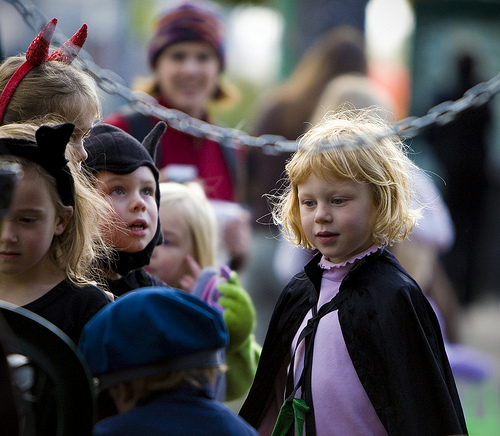

Image 1:
  Generated: a man in a white shirt and sunglasses is standing in front of a crowd of people . <EOS>
  Original:  A blonde girl in a black cape stands with other children in costumes .
--------------------------------------------------


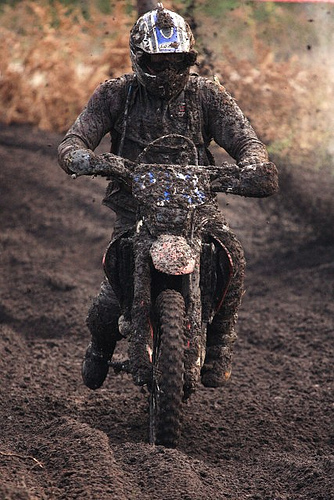

Image 2:
  Generated: a man is riding a bike on a dirt bike . <EOS>
  Original:  Man in a helmet riding a dirt bike covered with mud .
--------------------------------------------------


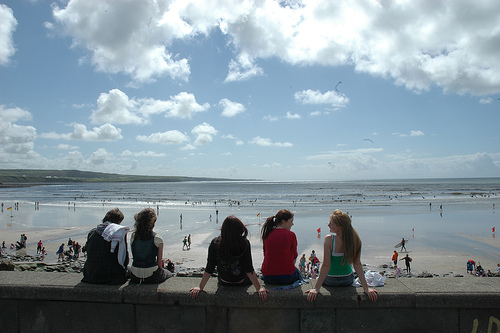

Image 3:
  Generated: a man is standing on a beach with a stick in the background . <EOS>
  Original:  Crowd of people at the beach .
--------------------------------------------------


In [25]:
loaded_model.eval() # Ensure model is in evaluation mode

print("\n--- Post-training captions ---")

for i, sample in enumerate(test_samples):
    display(sample['image'])
    
    with torch.no_grad():
        caption = loaded_model.caption_image(test_images[i].unsqueeze(0))
        caption_text = ' '.join(caption)
        print(f"Image {i+1}:")
        print(f"  Generated: {caption_text}")
        print(f"  Original:  {sample['caption']}")
        print("-" * 50)

## 8️⃣ Conclusion & Next Steps

We have successfully built, trained, and evaluated an image captioning model using a CNN encoder and a **Transformer decoder**. The results, even after a short training run, show the power of the attention mechanism in both understanding the image and generating coherent language.

### **📝 Exercises for Further Exploration**
1.  **More Training**: The most impactful change would be to train for more `epochs` on a larger portion of the dataset (or the full dataset). Deep learning models are data-hungry!
2.  **Hyperparameter Tuning**: Experiment with different values for `embed_size`, `num_decoder_layers`, `heads`, and `learning_rate`.
3.  **Different Encoders**: Try a different pre-trained CNN as the encoder. For example, use `Inception_V3` (which requires a different input image size, `299x299`) or a more modern `EfficientNet`.
4.  **Beam Search Decoding**: The current `caption_image` method uses greedy decoding (picking the single best word at each step). Implement **beam search**, which keeps track of the `k` most probable sequences at each step, often resulting in higher-quality and more diverse final captions. This is a standard technique for improving generation quality at inference time.
5.  **Compare with RNN**: Now that you have two well-structured notebooks, compare the performance (final loss, quality of generated captions) of the Transformer-based model against the RNN-based model. Which one trains faster? Which gives better results for the same number of epochs?

### Contributed by: Ali Habibullah